# Figure 1 boxplots

We want to know how many splice junctions are annotated as NMD/unproductive in the multiple RNA assays. We will use the mappings that were used for all other analyses.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr

intron_annot = pd.read_csv('../data/IntronAnnotationsFromYang.tsv.gz', sep='\t')
intron_annot['junction'] = intron_annot[['chrom', 'start', 'end', 'strand']].astype(str).agg(':'.join, axis=1)

In [4]:
RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/Expression.Splicing.Subset_YRI/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

YRI_samples = RPKM.columns[5:]

def get_junction_counts(phenotype='chRNA.Expression.Splicing', subset_samples=[], remove_sample=None):
    
    template = '../code/SplicingAnalysis/leafcutter/clustering/autosomes/leafcutter_perind.counts.gz.{Phenotype}.gz'
    counts = pd.read_csv(template.format(Phenotype=phenotype), sep=' ')
    
    if len(subset_samples) > 0:
        counts = counts[['chrom'] + list(subset_samples)]
        counts.columns = ['cluster_id'] + list(subset_samples)
        
    if remove_sample:
        counts = counts.drop(remove_sample, axis=1)

    
    
    samples = list(counts.columns[1:])
    counts.columns = ['cluster_id'] + samples

    counts[['chrom', 'start', 'end', 'cluster']] = counts['cluster_id'].str.split(':', 3, expand=True)

    counts['strand'] = [x.split('_')[-1] for x in counts.cluster]
    counts['intron'] = counts.chrom + ':' + counts.start.astype(str)+ ':' + counts.end.astype(str) + ':' + counts.strand

    for sample in samples:
        counts[[sample, sample+'_total']] = counts[sample].str.split('/', 1, expand=True)

    counts = counts[['chrom', 'start', 'end', 'cluster', 'intron', 'strand'] + samples]

    counts['start'] = counts['start'].astype(int)
    counts['end'] = counts['end'].astype(int)
    counts[samples] = counts[samples].astype(int)
    
    return counts, samples
    

chRNA, chRNA_samples = get_junction_counts(phenotype='chRNA.Expression.Splicing', remove_sample='NA18855')
ml30, ml30_samples = get_junction_counts(phenotype='MetabolicLabelled.30min')
ml60, ml60_samples = get_junction_counts(phenotype='MetabolicLabelled.60min')
polyA, polyA_samples = get_junction_counts(phenotype='Expression.Splicing', subset_samples=YRI_samples)



In [5]:
def annotate_counts(counts, intron_annot):
    X_annotated = intron_annot.merge(counts, left_on = ['chrom', 'start', 'end', 'junction', 'strand'], 
                   right_on = ['chrom', 'start', 'end', 'intron', 'strand'])


#     X_CodingGene = X_annotated.loc[X_annotated.SuperAnnotation.str.contains('CodingGene')].copy()

    X_annotated[['Annotated', 'Isoform_type']] = X_annotated['SuperAnnotation'].str.split('_', 1, expand=True)
    X_annotated = X_annotated.reset_index(drop=True)
    X_annotated['intron_length'] = X_annotated.end - X_annotated.start
    
    return X_annotated

chRNA_annotated = annotate_counts(chRNA, intron_annot)
ml30_annotated = annotate_counts(ml30, intron_annot)
ml60_annotated = annotate_counts(ml60, intron_annot)
polyA_annotated = annotate_counts(polyA, intron_annot)

In [6]:
def GetJunctionProportions(X_annotated, samples):
    unprod_counts = X_annotated.loc[X_annotated.Isoform_type == 'UnproductiveCodingGene', samples].sum(axis=0)
    prod_counts = X_annotated.loc[X_annotated.Isoform_type == 'ProductiveCodingGene', samples].sum(axis=0)
    noncoding_counts = X_annotated.loc[X_annotated.Isoform_type == 'NoncodingGene', samples].sum(axis=0)
    all_counts = X_annotated.loc[:, samples].sum(axis=0)
    
    unprod_counts = 100*unprod_counts/all_counts
    prod_counts = 100*prod_counts/all_counts
    noncoding_counts = 100*noncoding_counts/all_counts
    
    return unprod_counts, prod_counts, noncoding_counts, all_counts


## All junction reads

Here we use all junction reads, both annotated and unannotated.

Junctions that are annotated as belonging to a protein coding isoform of a protein coding gene are labelled as producitve. Junctions that are annotated as belonging to NMD isoforms, processed transcripts, or that are unannotated but switch the reading frame, are annotated as unproductive. Junctions that do not fall in protein coding genes are annotated as non-coding.

In [15]:
chRNA_unprod, chRNA_prod, chRNA_noncoding, chRNA_all = GetJunctionProportions(chRNA_annotated, chRNA_samples)
ml30_unprod, ml30_prod, ml30_noncoding, ml30_all = GetJunctionProportions(ml30_annotated, ml30_samples)
ml60_unprod, ml60_prod, ml60_noncoding, ml60_all = GetJunctionProportions(ml60_annotated, ml60_samples)
polyA_unprod, polyA_prod, polyA_noncoding, polyA_all = GetJunctionProportions(polyA_annotated, polyA_samples)

nmd_df = pd.DataFrame()
unprod_ratio = list(chRNA_unprod) + list(ml30_unprod) + list(ml60_unprod) + list(polyA_unprod)
prod_ratio = list(chRNA_prod) + list(ml30_prod) + list(ml60_prod) + list(polyA_prod) 
noncoding_ratio = list(chRNA_noncoding) + list(ml30_noncoding) + list(ml60_noncoding) + list(polyA_noncoding) 
pheno = (['chRNA'] * len(chRNA_prod)) + (['4sU 30min'] * len(ml30_prod))
pheno += (['4sU 60min'] * len(ml60_prod)) + (['polyA'] * len(polyA_prod))
nmd_df['phenotype'] = pheno
nmd_df['unprod_ratio'] = unprod_ratio
nmd_df['prod_ratio'] = prod_ratio
nmd_df['noncoding_ratio'] = noncoding_ratio

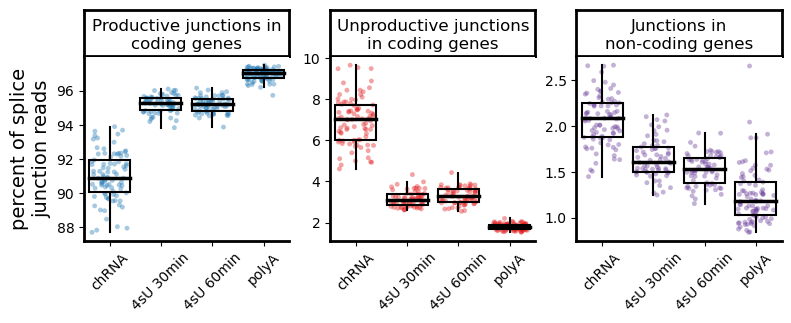

In [16]:
# fig, ax = plt.subplots(nrows=1, ncols=3,  gridspec_kw={'wspace': 0.3}, figsize=(10, 3))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


sns.stripplot(data = nmd_df, x = 'phenotype', y = 'prod_ratio', jitter=0.35, ax=ax[1, 0], alpha=0.4, 
              color='#1f78b4', zorder=0, linewidth=0, edgecolor=None, s=3.5)
sns.boxplot(data = nmd_df, x = 'phenotype', y = 'prod_ratio', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

sns.stripplot(data = nmd_df, x = 'phenotype', y = 'unprod_ratio', jitter=0.35, ax=ax[1, 1], alpha=0.4, 
              color='#e31a1c', zorder=0, linewidth=0, edgecolor=None, s=3.5)
sns.boxplot(data = nmd_df, x = 'phenotype', y = 'unprod_ratio', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

sns.stripplot(data = nmd_df, x = 'phenotype', y = 'noncoding_ratio', jitter=0.35, ax=ax[1, 2], alpha=0.4, 
              color='#6a3d9a', zorder=0, linewidth=0, edgecolor=None, s=3.5)
sns.boxplot(data = nmd_df, x = 'phenotype', y = 'noncoding_ratio', width=0.8, ax=ax[1, 2], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

for x in range(3):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(3):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# title = ax[0].set_title('protein coding') 
# bbox = title.get_bbox_patch()
# bbox.set_boxstyle("round,pad=0.3")
# bbox.set_edgecolor("blue")
# bbox.set_facecolor("lightblue")

ax[1, 0].set_title('Productive junctions in\ncoding genes')
ax[1, 1].set_title('Unproductive junctions\nin coding genes')
ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
ax[1, 2].set_ylabel('')
ax[1, 0].set_ylabel('percent of splice\njunction reads', size=14)

plt.savefig('../code/plots/Fig1.NMD_percent.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/plots/Fig1.NMD_percent.png', dpi=300, bbox_inches='tight',)

As expected, chRNA has more unproductive reads than the other assays, while polyA RNA-seq has almost no unproductive reads. It seems that 7% of the total junction reads in chRNA are unproductive... That is a massive amount of reads. Let's see if this comes from many unannotated reads.

## Annotated reads only

In [10]:
chRNA_unprod, chRNA_prod, chRNA_noncoding, chRNA_all = GetJunctionProportions(chRNA_annotated.loc[chRNA_annotated.Annotated == 'AnnotatedJunc'], chRNA_samples)
ml30_unprod, ml30_prod, ml30_noncoding, ml30_all = GetJunctionProportions(ml30_annotated.loc[ml30_annotated.Annotated == 'AnnotatedJunc'], ml30_samples)
ml60_unprod, ml60_prod, ml60_noncoding, ml60_all = GetJunctionProportions(ml60_annotated.loc[ml60_annotated.Annotated == 'AnnotatedJunc'], ml60_samples)
polyA_unprod, polyA_prod, polyA_noncoding, polyA_all = GetJunctionProportions(polyA_annotated.loc[polyA_annotated.Annotated == 'AnnotatedJunc'], polyA_samples)


nmd_df = pd.DataFrame()
unprod_ratio = list(chRNA_unprod) + list(ml30_unprod) + list(ml60_unprod) + list(polyA_unprod)
prod_ratio = list(chRNA_prod) + list(ml30_prod) + list(ml60_prod) + list(polyA_prod) 
noncoding_ratio = list(chRNA_noncoding) + list(ml30_noncoding) + list(ml60_noncoding) + list(polyA_noncoding) 
pheno = (['chRNA'] * len(chRNA_prod)) + (['4sU 30min'] * len(ml30_prod))
pheno += (['4sU 60min'] * len(ml60_prod)) + (['polyA'] * len(polyA_prod))
nmd_df['phenotype'] = pheno
nmd_df['unprod_ratio'] = unprod_ratio
nmd_df['prod_ratio'] = prod_ratio
nmd_df['noncoding_ratio'] = noncoding_ratio

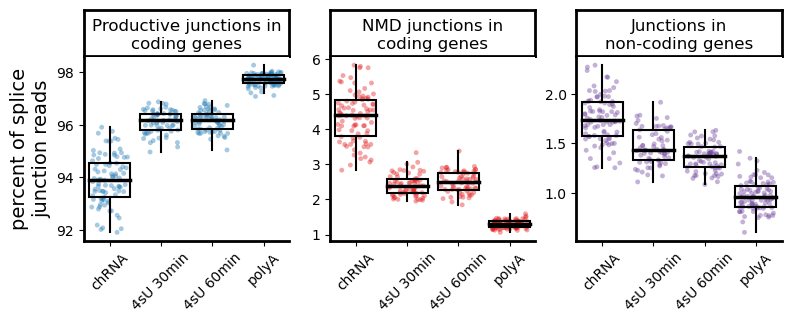

In [11]:
# fig, ax = plt.subplots(nrows=1, ncols=3,  gridspec_kw={'wspace': 0.3}, figsize=(10, 3))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


sns.stripplot(data = nmd_df, x = 'phenotype', y = 'prod_ratio', jitter=0.35, ax=ax[1, 0], alpha=0.4, 
              color='#1f78b4', zorder=0, linewidth=0, edgecolor=None, s=3.5)
sns.boxplot(data = nmd_df, x = 'phenotype', y = 'prod_ratio', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

sns.stripplot(data = nmd_df, x = 'phenotype', y = 'unprod_ratio', jitter=0.35, ax=ax[1, 1], alpha=0.4, 
              color='#e31a1c', zorder=0, linewidth=0, edgecolor=None, s=3.5)
sns.boxplot(data = nmd_df, x = 'phenotype', y = 'unprod_ratio', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

sns.stripplot(data = nmd_df, x = 'phenotype', y = 'noncoding_ratio', jitter=0.35, ax=ax[1, 2], alpha=0.4, 
              color='#6a3d9a', zorder=0, linewidth=0, edgecolor=None, s=3.5)
sns.boxplot(data = nmd_df, x = 'phenotype', y = 'noncoding_ratio', width=0.8, ax=ax[1, 2], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

for x in range(3):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(3):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# title = ax[0].set_title('protein coding') 
# bbox = title.get_bbox_patch()
# bbox.set_boxstyle("round,pad=0.3")
# bbox.set_edgecolor("blue")
# bbox.set_facecolor("lightblue")

ax[1, 0].set_title('Productive junctions in\ncoding genes')
ax[1, 1].set_title('NMD junctions in\ncoding genes')
ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
ax[1, 2].set_ylabel('')
ax[1, 0].set_ylabel('percent of splice\njunction reads', size=14)

plt.savefig('../code/plots/Fig1.NMD_percent.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/plots/Fig1.NMD_percent.png', dpi=300, bbox_inches='tight',)

The percent of annotated reads that are unproductive in chRNA is reduced to 4.5%... which is still a very large number. These results suggest that NMD isoforms are produced at much higher rates than it was originally anticipated.

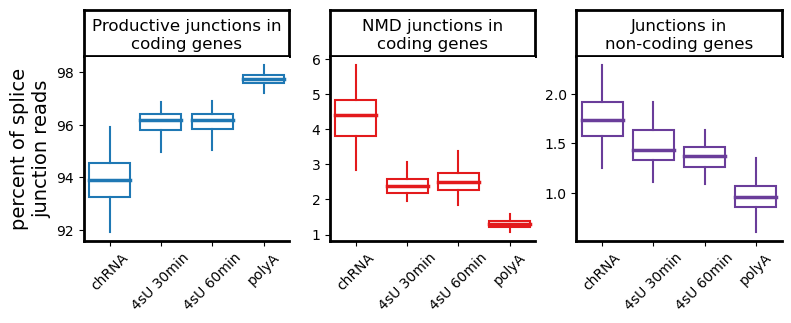

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


# sns.stripplot(data = nmd_df, x = 'phenotype', y = 'prod_ratio', jitter=0.35, ax=ax[1, 0], alpha=0.4, 
#               color='#1f78b4', zorder=0, linewidth=0, edgecolor=None)
sns.boxplot(data = nmd_df, x = 'phenotype', y = 'prod_ratio', width=0.8, ax=ax[1, 0], zorder=4,
                     linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#1f78b4'),
            whiskerprops=dict(color='#1f78b4'),
            medianprops=dict(color='#1f78b4', linewidth=2.5),
            capprops={'linewidth':0, })

# sns.stripplot(data = nmd_df, x = 'phenotype', y = 'unprod_ratio', jitter=0.35, ax=ax[1, 1], alpha=0.4, 
#               color='#e31a1c', zorder=0, linewidth=0, edgecolor=None)
sns.boxplot(data = nmd_df, x = 'phenotype', y = 'unprod_ratio', width=0.8, ax=ax[1, 1], zorder=4,
                     linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#e31a1c'),
            whiskerprops=dict(color='#e31a1c'),
            medianprops=dict(color='#e31a1c', linewidth=2.5),
            capprops={'linewidth':0, })

# sns.stripplot(data = nmd_df, x = 'phenotype', y = 'noncoding_ratio', jitter=0.35, ax=ax[1, 2], alpha=0.4, 
#               color='#6a3d9a', zorder=0, linewidth=0, edgecolor=None)

sns.boxplot(data = nmd_df, x = 'phenotype', y = 'noncoding_ratio', width=0.8, ax=ax[1, 2], zorder=4,
                     linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#6a3d9a'),
            whiskerprops=dict(color='#6a3d9a'),
            medianprops=dict(color='#6a3d9a', linewidth=2.5),
            capprops={'linewidth':0, })

for x in range(3):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(3):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# title = ax[0].set_title('protein coding') 
# bbox = title.get_bbox_patch()
# bbox.set_boxstyle("round,pad=0.3")
# bbox.set_edgecolor("blue")
# bbox.set_facecolor("lightblue")

ax[1, 0].set_title('Productive junctions in\ncoding genes')
ax[1, 1].set_title('NMD junctions in\ncoding genes')
ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
ax[1, 2].set_ylabel('')
ax[1, 0].set_ylabel('percent of splice\njunction reads', size=14)

plt.savefig('plots/Fig1.NMD_percent_box.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('plots/Fig1.NMD_percent_box.png', dpi=300, bbox_inches='tight',)

## Junction reads by annotated tag

Next we'll explore the makeup of the 4.5% of junction reads that are annotated as unproductive in chRNA.

In [10]:
chRNA_annotated.SemiSupergroupAnnotations.unique()

array(['overlaps pseudogene', 'uniquely psueodgene tag',
       'uniquely lncRNA tag', 'overlaps lncRNA',
       'uniquely processed_transcript tag',
       'overlaps processed transcript intron',
       'uniquely retained_intron tag', 'basic tag', 'predicted_NMD YN',
       'predicted_NMD pstopcodon', 'frame preserving skipped exon',
       'predicted_NMD far3p', 'predicted_NMD UTRjunction',
       'predicted_NMD far5p', 'uniquely nonsense_mediated_decay tag',
       'predicted_NMD reason2', 'overlaps nonsense_mediated_decay intron',
       'stable.NY', 'overlaps retained_intron tag', 'predicted_NMD NN',
       'uniquely non_stop_decay tag', 'predicted_NMD reason1',
       'overlaps hypervariable gene', 'hypervariable genes tag'],
      dtype=object)

In [12]:
pred_NMD = [x for x in chRNA_annotated.SemiSupergroupAnnotations.unique() if 'predicted_NMD' in x]

In [27]:
predicted_nmd_chRNA = chRNA_annotated.loc[chRNA_annotated.SemiSupergroupAnnotations.isin(pred_NMD), 
                                chRNA_samples].sum(axis=0)/chRNA_annotated[chRNA_samples].sum(axis=0)

annotated_nmd_chRNA = chRNA_annotated.loc[chRNA_annotated.SemiSupergroupAnnotations == 'uniquely nonsense_mediated_decay tag', 
                                chRNA_samples].sum(axis=0)/chRNA_annotated[chRNA_samples].sum(axis=0)

annot_processed_transcript_chRNA = chRNA_annotated.loc[
    chRNA_annotated.SemiSupergroupAnnotations == 'uniquely processed_transcript tag', 
    chRNA_samples].sum(axis=0)/chRNA_annotated[chRNA_samples].sum(axis=0)

predicted_nmd_ml30 = ml30_annotated.loc[ml30_annotated.SemiSupergroupAnnotations.isin(pred_NMD), 
                                ml30_samples].sum(axis=0)/ml30_annotated[ml30_samples].sum(axis=0)

annotated_nmd_ml30 = ml30_annotated.loc[ml30_annotated.SemiSupergroupAnnotations == 'uniquely nonsense_mediated_decay tag', 
                                ml30_samples].sum(axis=0)/ml30_annotated[ml30_samples].sum(axis=0)

annot_processed_transcript_ml30 = ml30_annotated.loc[
    ml30_annotated.SemiSupergroupAnnotations == 'uniquely processed_transcript tag', 
    ml30_samples].sum(axis=0)/ml30_annotated[ml30_samples].sum(axis=0)

predicted_nmd_ml60 = ml60_annotated.loc[ml60_annotated.SemiSupergroupAnnotations.isin(pred_NMD), 
                                ml60_samples].sum(axis=0)/ml60_annotated[ml60_samples].sum(axis=0)

annotated_nmd_ml60 = ml60_annotated.loc[ml60_annotated.SemiSupergroupAnnotations == 'uniquely nonsense_mediated_decay tag', 
                                ml60_samples].sum(axis=0)/ml60_annotated[ml60_samples].sum(axis=0)

annot_processed_transcript_ml60 = ml60_annotated.loc[
    ml60_annotated.SemiSupergroupAnnotations == 'uniquely processed_transcript tag', 
    ml60_samples].sum(axis=0)/ml60_annotated[ml60_samples].sum(axis=0)

predicted_nmd_polyA = polyA_annotated.loc[polyA_annotated.SemiSupergroupAnnotations.isin(pred_NMD), 
                                polyA_samples].sum(axis=0)/polyA_annotated[polyA_samples].sum(axis=0)

annotated_nmd_polyA = polyA_annotated.loc[polyA_annotated.SemiSupergroupAnnotations == 'uniquely nonsense_mediated_decay tag', 
                                polyA_samples].sum(axis=0)/polyA_annotated[polyA_samples].sum(axis=0)

annot_processed_transcript_polyA = polyA_annotated.loc[
    polyA_annotated.SemiSupergroupAnnotations == 'uniquely processed_transcript tag', 
    polyA_samples].sum(axis=0)/polyA_annotated[polyA_samples].sum(axis=0)

# annot_processed_transcript_chRNA = chRNA_annotated.loc[
#     chRNA_annotated.SemiSupergroupAnnotations == 'uniquely processed_transcript tag', 
#     chRNA_samples].sum(axis=0)/chRNA_annotated[chRNA_samples].sum(axis=0)

# annot_processed_transcript_ml30 = ml30_annotated.loc[
#     ml30_annotated.SemiSupergroupAnnotations == 'uniquely processed_transcript tag', 
#     ml30_samples].sum(axis=0)/ml30_annotated[ml30_samples].sum(axis=0)



In [32]:
nmd_df = pd.DataFrame()
pred_nmd = list(predicted_nmd_chRNA) + list(predicted_nmd_ml30) + list(predicted_nmd_ml60) + list(predicted_nmd_polyA)
annotated_nmd = list(annotated_nmd_chRNA) + list(annotated_nmd_ml30) + list(annotated_nmd_ml60) + list(annotated_nmd_polyA)
annotated_pt = list(annot_processed_transcript_chRNA) + list(annot_processed_transcript_ml30) + list(annot_processed_transcript_ml60) + list(annot_processed_transcript_polyA)
pheno = (['chRNA'] * len(chRNA_prod)) + (['4sU 30min'] * len(ml30_prod))
pheno += (['4sU 60min'] * len(ml60_prod)) + (['polyA'] * len(polyA_prod))
nmd_df['phenotype'] = pheno
nmd_df['pred_nmd'] = np.array(pred_nmd)*100
nmd_df['annotated_nmd'] = np.array(annotated_nmd)*100
nmd_df['annotated_pt'] = np.array(annotated_pt)*100

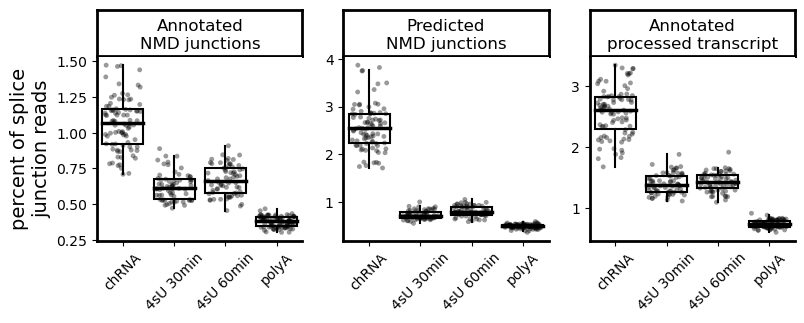

In [35]:
# fig, ax = plt.subplots(nrows=1, ncols=3,  gridspec_kw={'wspace': 0.3}, figsize=(10, 3))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


sns.stripplot(data = nmd_df, x = 'phenotype', y = 'annotated_nmd', jitter=0.35, ax=ax[1, 0], alpha=0.4, 
              color='black', zorder=0, linewidth=0, edgecolor=None, s=3.5)
sns.boxplot(data = nmd_df, x = 'phenotype', y = 'annotated_nmd', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

sns.stripplot(data = nmd_df, x = 'phenotype', y = 'pred_nmd', jitter=0.35, ax=ax[1, 1], alpha=0.4, 
              color='black', zorder=0, linewidth=0, edgecolor=None, s=3.5)
sns.boxplot(data = nmd_df, x = 'phenotype', y = 'pred_nmd', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

sns.stripplot(data = nmd_df, x = 'phenotype', y = 'annotated_pt', jitter=0.35, ax=ax[1, 2], alpha=0.4, 
              color='black', zorder=0, linewidth=0, edgecolor=None, s=3.5)
sns.boxplot(data = nmd_df, x = 'phenotype', y = 'annotated_pt', width=0.8, ax=ax[1, 2], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

for x in range(3):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(3):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# title = ax[0].set_title('protein coding') 
# bbox = title.get_bbox_patch()
# bbox.set_boxstyle("round,pad=0.3")
# bbox.set_edgecolor("blue")
# bbox.set_facecolor("lightblue")

ax[1, 0].set_title('Annotated\nNMD junctions')
ax[1, 1].set_title('Predicted\nNMD junctions')
ax[1, 2].set_title('Annotated\nprocessed transcript')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
ax[1, 2].set_ylabel('')
ax[1, 0].set_ylabel('percent of splice\njunction reads', size=14)

plt.show()

# plt.savefig('../code/plots/Fig1.NMD_percent.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig('../code/plots/Fig1.NMD_percent.png', dpi=300, bbox_inches='tight',)

## Expression and intron length confounders

In [32]:
X_annotated = intron_annot.merge(chRNA, left_on = ['chrom', 'start', 'end', 'junction', 'strand'], 
                   right_on = ['chrom', 'start', 'end', 'intron', 'strand'])


X_CodingGene = X_annotated.loc[X_annotated.SuperAnnotation.str.contains('CodingGene')].copy()

X_CodingGene[['Annotated', 'Isoform_type']] = X_CodingGene['SuperAnnotation'].str.split('_', 1, expand=True)
X_CodingGene = X_CodingGene.reset_index(drop=True)
X_CodingGene['intron_length'] = X_CodingGene.end - X_CodingGene.start

In [33]:
X_CodingGene = chRNA_annotated.loc[chRNA_annotated.SuperAnnotation.str.contains('CodingGene')].copy()

cluster_by_length = X_CodingGene.loc[
    (X_CodingGene.Isoform_type == 'ProductiveCodingGene')
].groupby('cluster').intron_length.max().sort_values()

In [34]:
def get_series_quantile(series, gene_list=None, quant=4):
    
    if not gene_list is None:
        series = series.loc[gene_list].dropna()
    
    q = 1/quant
    
    seriesQ_list = []
    
    for i in range(quant):
        Qi = series.quantile(q*i)
        Qi2 = series.quantile(q*(i+1))
        if i == 0:
            Qi -= 1
        if i == (quant-1):
            Qi2 += 1
        seriesQi = series.loc[(series >= Qi) & (series < Qi2)].index
        
        seriesQ_list.append(seriesQi)
        
    return seriesQ_list

In [35]:
Qlen_1, Qlen_2, Qlen_3, Qlen_4 =  get_series_quantile(cluster_by_length)

In [36]:
def get_unproductive_ratio(juncs, Qname, Qlist):
    
    
    juncs_Q_prod = juncs.loc[
        juncs[Qname].isin(Qlist) & (juncs.Isoform_type == 'ProductiveCodingGene'), chRNA_samples
    ].sum(axis=0)
    
    juncs_Q_unprod = juncs.loc[
        juncs[Qname].isin(Qlist) & (juncs.Isoform_type == 'UnproductiveCodingGene'), chRNA_samples
    ].sum(axis=0)
    
    unprod_ratio = list(100*juncs_Q_unprod/(juncs_Q_unprod + juncs_Q_prod))
    
    return unprod_ratio


In [279]:
# unproductive_genes_Q1 = X_CodingGene.loc[X_CodingGene.cluster.isin(Qlen_1) & (X_CodingGene.Isoform_type == 'UnproductiveCodingGene'),
#                 chRNA_samples].sum(axis=0)
                         
# productive_genes_Q1 = X_CodingGene.loc[X_CodingGene.cluster.isin(Qlen_1),
#                 chRNA_samples].sum(axis=0)
# nmd_Q1 = list(unproductive_genes_Q1/(productive_genes_Q1 + unproductive_genes_Q1))
                         
# unproductive_genes_Q2 = X_CodingGene.loc[X_CodingGene.cluster.isin(Qlen_2) & (X_CodingGene.Isoform_type == 'UnproductiveCodingGene'),
#                 chRNA_samples].sum(axis=0)
# productive_genes_Q2 = X_CodingGene.loc[X_CodingGene.cluster.isin(Qlen_2),
#                 chRNA_samples].sum(axis=0)
# nmd_Q2 = list(unproductive_genes_Q2/(productive_genes_Q2 + unproductive_genes_Q2))

# unproductive_genes_Q3 = X_CodingGene.loc[X_CodingGene.cluster.isin(Qlen_3) & (X_CodingGene.Isoform_type == 'UnproductiveCodingGene'),
#                 chRNA_samples].sum(axis=0)
# productive_genes_Q3 = X_CodingGene.loc[X_CodingGene.cluster.isin(Qlen_3),
#                 chRNA_samples].sum(axis=0)
# nmd_Q3 = list(unproductive_genes_Q3/(productive_genes_Q3 + unproductive_genes_Q3))
                         
# unproductive_genes_Q4 = X_CodingGene.loc[X_CodingGene.cluster.isin(Qlen_4) & (X_CodingGene.Isoform_type == 'UnproductiveCodingGene'),
#                 chRNA_samples].sum(axis=0)
# productive_genes_Q4 = X_CodingGene.loc[X_CodingGene.cluster.isin(Qlen_4),
#                 chRNA_samples].sum(axis=0)
# nmd_Q4 = list(unproductive_genes_Q4/(productive_genes_Q4 + unproductive_genes_Q4))

In [37]:
nmd_Q1 = get_unproductive_ratio(chRNA_annotated, 'cluster', Qlen_1) 
nmd_Q2 = get_unproductive_ratio(chRNA_annotated, 'cluster', Qlen_2) 
nmd_Q3 = get_unproductive_ratio(chRNA_annotated, 'cluster', Qlen_3) 
nmd_Q4 = get_unproductive_ratio(chRNA_annotated, 'cluster', Qlen_4) 


nmd_by_exp_df = pd.DataFrame()
nmd_by_exp_df['nmd_percent'] = nmd_Q1 + nmd_Q2 + nmd_Q3 + nmd_Q4# + nmd_Q5
nmd_by_exp_df['quartile'] = ['Q1']*len(nmd_Q1)+['Q2']*len(nmd_Q2)+['Q3']*len(nmd_Q3)+['Q4']*len(nmd_Q4)#+['Q5']*len(nmd_Q5)

In [303]:
# fig, ax = plt.subplots(figsize=(3, 3))


# sns.stripplot(data = nmd_by_exp_df, x = 'quartile', y='nmd_percent', jitter=0.25, ax=ax, alpha=0.4, 
#               color='dodgerblue', zorder=0, linewidth=0, edgecolor=None)
# sns.boxplot(data = nmd_by_exp_df, x = 'quartile', y='nmd_percent', width=0.6, ax=ax, zorder=4,
#                     color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
#             boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

In [38]:
RPKM = pd.read_csv(
    'QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

In [39]:
chRNA_samples = [x for x in RPKM.columns if ((x[:2] == 'NA') and (x != 'NA18855'))]
RPKM_median = RPKM[chRNA_samples].median(axis=1)

In [40]:
Q1, Q2, Q3, Q4 = get_series_quantile(RPKM_median, gene_list = pd.Index(chRNA_annotated.gene.unique()).intersection(RPKM.index))

In [41]:
   
juncs_chRNA_Q1 = get_unproductive_ratio(chRNA_annotated, 'gene', Q1) 
juncs_chRNA_Q2 = get_unproductive_ratio(chRNA_annotated, 'gene', Q2) 
juncs_chRNA_Q3 = get_unproductive_ratio(chRNA_annotated, 'gene', Q3) 
juncs_chRNA_Q4 = get_unproductive_ratio(chRNA_annotated, 'gene', Q4) 

dfQ = pd.DataFrame()
dfQ['unproductive_rate'] = juncs_chRNA_Q1 + juncs_chRNA_Q2 + juncs_chRNA_Q3 + juncs_chRNA_Q4

quart = (['Q1']*len(juncs_chRNA_Q1)) + (['Q2']*len(juncs_chRNA_Q1)) 
quart += (['Q3']*len(juncs_chRNA_Q1)) + (['Q4']*len(juncs_chRNA_Q1))
dfQ['quartile'] = quart

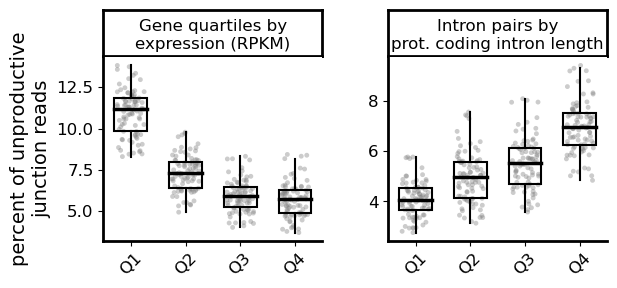

In [42]:

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6.5, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.3, 'hspace': 0.01})


sns.stripplot(data=dfQ, x='quartile', y = 'unproductive_rate', jitter=0.25, ax=ax[1, 0], alpha=0.4, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=3.5)
sns.boxplot(data=dfQ, x='quartile', y = 'unproductive_rate', width=0.6, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

sns.stripplot(data = nmd_by_exp_df, x = 'quartile', y='nmd_percent', jitter=0.25, ax=ax[1, 1], alpha=0.4, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=3.5)
sns.boxplot(data = nmd_by_exp_df, x = 'quartile', y='nmd_percent', width=0.6, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})



for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    


ax[1, 0].set_title('Gene quartiles by\nexpression (RPKM)')
ax[1, 1].set_title('Intron pairs by\nprot. coding intron length')

ax[1, 1].set_ylabel('')
ax[1, 0].set_ylabel('percent of unproductive\njunction reads', size=14)

ax[1,0].tick_params(labelsize =12)
ax[1,1].tick_params(labelsize =12)

# plt.savefig('nmd_by_quartiles.pdf', bbox_inches='tight', 
#                transparent=True,
#                pad_inches=0)

plt.savefig('plots/Fig1.NMD_confounders.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('plots/Fig1.NMD_confounders.png', dpi=300, bbox_inches='tight',)

In [43]:
nmd_Q1 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q1)], 'cluster', Qlen_1) 
nmd_Q2 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q1)], 'cluster', Qlen_2) 
nmd_Q3 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q1)], 'cluster', Qlen_3) 
nmd_Q4 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q1)], 'cluster', Qlen_4) 


nmd_by_exp_df = pd.DataFrame()
nmd_by_exp_df['nmd_percent'] = nmd_Q1 + nmd_Q2 + nmd_Q3 + nmd_Q4# + nmd_Q5
nmd_by_exp_df['quartile'] = ['Q1']*len(nmd_Q1)+['Q2']*len(nmd_Q2)+['Q3']*len(nmd_Q3)+['Q4']*len(nmd_Q4)#+['Q5']*len(nmd_Q5)

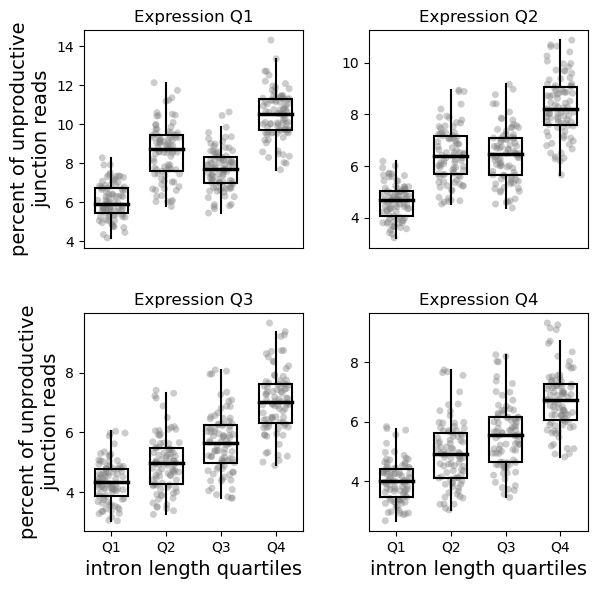

In [47]:


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6.5, 6.5), gridspec_kw={'wspace': 0.3, 'hspace': 0.3})

juncs_Q1len_Q1 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q1)], 'cluster', Qlen_1) 
juncs_Q2len_Q1 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q1)], 'cluster', Qlen_2) 
juncs_Q3len_Q1 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q1)], 'cluster', Qlen_3) 
juncs_Q4len_Q1 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q1)], 'cluster', Qlen_4) 


dfQ_len = pd.DataFrame()
dfQ_len['unproductive_rate'] = juncs_Q1len_Q1 + juncs_Q2len_Q1 + juncs_Q3len_Q1 + juncs_Q4len_Q1
dfQ_len['quartile'] = ['Q1']*len(nmd_Q1)+['Q2']*len(nmd_Q2)+['Q3']*len(nmd_Q3)+['Q4']*len(nmd_Q4)

sns.stripplot(data=dfQ_len, x='quartile', y = 'unproductive_rate', jitter=0.25, ax=ax[0,0], alpha=0.4, 
              color='gray', zorder=0, linewidth=0, edgecolor=None)
sns.boxplot(data=dfQ_len, x='quartile', y = 'unproductive_rate', width=0.6, ax=ax[0,0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})



juncs_Q1len_Q2 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q2)], 'cluster', Qlen_1) 
juncs_Q2len_Q2 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q2)], 'cluster', Qlen_2) 
juncs_Q3len_Q2 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q2)], 'cluster', Qlen_3) 
juncs_Q4len_Q2 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q2)], 'cluster', Qlen_4) 


dfQ_len = pd.DataFrame()
dfQ_len['unproductive_rate'] = juncs_Q1len_Q2 + juncs_Q2len_Q2 + juncs_Q3len_Q2 + juncs_Q4len_Q2
dfQ_len['quartile'] = ['Q1']*len(nmd_Q1)+['Q2']*len(nmd_Q2)+['Q3']*len(nmd_Q3)+['Q4']*len(nmd_Q4)

sns.stripplot(data=dfQ_len, x='quartile', y = 'unproductive_rate', jitter=0.25, ax=ax[0,1], alpha=0.4, 
              color='gray', zorder=0, linewidth=0, edgecolor=None)
sns.boxplot(data=dfQ_len, x='quartile', y = 'unproductive_rate', width=0.6, ax=ax[0,1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})


juncs_Q1len_Q3 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q3)], 'cluster', Qlen_1) 
juncs_Q2len_Q3 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q3)], 'cluster', Qlen_2) 
juncs_Q3len_Q3 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q3)], 'cluster', Qlen_3) 
juncs_Q4len_Q3 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q3)], 'cluster', Qlen_4) 


dfQ_len = pd.DataFrame()
dfQ_len['unproductive_rate'] = juncs_Q1len_Q3 + juncs_Q2len_Q3 + juncs_Q3len_Q3 + juncs_Q4len_Q3
dfQ_len['quartile'] = ['Q1']*len(nmd_Q1)+['Q2']*len(nmd_Q2)+['Q3']*len(nmd_Q3)+['Q4']*len(nmd_Q4)

sns.stripplot(data=dfQ_len, x='quartile', y = 'unproductive_rate', jitter=0.25, ax=ax[1,0], alpha=0.4, 
              color='gray', zorder=0, linewidth=0, edgecolor=None)
sns.boxplot(data=dfQ_len, x='quartile', y = 'unproductive_rate', width=0.6, ax=ax[1,0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})


juncs_Q1len_Q4 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q4)], 'cluster', Qlen_1) 
juncs_Q2len_Q4 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q4)], 'cluster', Qlen_2) 
juncs_Q3len_Q4 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q4)], 'cluster', Qlen_3) 
juncs_Q4len_Q4 = get_unproductive_ratio(chRNA_annotated.loc[chRNA_annotated['gene'].isin(Q4)], 'cluster', Qlen_4) 


dfQ_len = pd.DataFrame()
dfQ_len['unproductive_rate'] = juncs_Q1len_Q4 + juncs_Q2len_Q4 + juncs_Q3len_Q4 + juncs_Q4len_Q4
dfQ_len['quartile'] = ['Q1']*len(nmd_Q1)+['Q2']*len(nmd_Q2)+['Q3']*len(nmd_Q3)+['Q4']*len(nmd_Q4)

sns.stripplot(data=dfQ_len, x='quartile', y = 'unproductive_rate', jitter=0.25, ax=ax[1,1], alpha=0.4, 
              color='gray', zorder=0, linewidth=0, edgecolor=None)
sns.boxplot(data=dfQ_len, x='quartile', y = 'unproductive_rate', width=0.6, ax=ax[1,1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

ax[0,0].set_title('Expression Q1')
ax[0,1].set_title('Expression Q2')
ax[1,0].set_title('Expression Q3')
ax[1,1].set_title('Expression Q4')

ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')

ax[0, 0].set_ylabel('percent of unproductive\njunction reads', size=14)
ax[1, 0].set_ylabel('percent of unproductive\njunction reads', size=14)


ax[1,0].set_xlabel('intron length quartiles', size=14)
ax[1,1].set_xlabel('intron length quartiles', size=14)

ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,0].set_xticks([])
ax[0,1].set_xticks([])


plt.savefig('plots/Fig1.NMD_expression_confounder.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('plots/Fig1.NMD_expression_confounder.png', dpi=300, bbox_inches='tight',)

In [122]:
2779202/102552092

0.02710039303732585

In [107]:
X_CodingGene.loc[X_CodingGene.Isoform_type == 'UnproductiveCodingGene', chRNA_samples].sum(axis=0)

NA18853    832303
NA19122    507438
NA18523    528661
NA18499    416146
NA18511    488651
            ...  
NA19108    548623
NA18505    312735
NA18502    606248
NA19203    542813
NA19128    546388
Length: 86, dtype: int64

In [101]:
X_CodingGene.loc[X_CodingGene.cluster.isin(cluster_by_length[:10000].index)]

,chrom,start,end,strand,NewAnnotation,gene,symbol,SuperAnnotation,SemiSupergroupAnnotations,junction,...,NA18876,NA18909,NA19108,NA18505,NA18502,NA19203,NA19128,Annotated,Isoform_type,intron_length
81,chr1,944800,945042,-,retained_intron.gencode,ENSG00000188976.11,NOC2L,AnnotatedJunc_UnproductiveCodingGene,uniquely retained_intron tag,chr1:944800:945042:-,...,39,12,49,55,121,87,71,AnnotatedJunc,UnproductiveCodingGene,242
82,chr1,944800,945057,-,protein_coding.gencode,ENSG00000188976.11,NOC2L,AnnotatedJunc_ProductiveCodingGene,basic tag,chr1:944800:945057:-,...,60,51,82,50,186,140,161,AnnotatedJunc,ProductiveCodingGene,257
83,chr1,944819,945042,-,nonsense_mediated_decay.YN,ENSG00000188976.11,NOC2L,UnannotatedJunc_UnproductiveCodingGene,predicted_NMD YN,chr1:944819:945042:-,...,2,0,0,0,0,0,0,UnannotatedJunc,UnproductiveCodingGene,223
84,chr1,944819,945057,-,nonsense_mediated_decay.YN,ENSG00000188976.11,NOC2L,UnannotatedJunc_UnproductiveCodingGene,predicted_NMD YN,chr1:944819:945057:-,...,0,0,0,0,1,0,6,UnannotatedJunc,UnproductiveCodingGene,238
85,chr1,945653,946147,-,nonsense_mediated_decay.pstopcodon,ENSG00000188976.11,NOC2L,UnannotatedJunc_UnproductiveCodingGene,predicted_NMD pstopcodon,chr1:945653:946147:-,...,0,3,0,4,8,4,4,UnannotatedJunc,UnproductiveCodingGene,494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165985,chr9,137272615,137272815,+,stable.YY,ENSG00000188986.9,NELFB,UnannotatedJunc_ProductiveCodingGene,frame preserving skipped exon,chr9:137272615:137272815:+,...,0,4,0,0,10,0,1,UnannotatedJunc,ProductiveCodingGene,200
166000,chr9,137434079,137434203,+,protein_coding.gencode,ENSG00000188747.8,NOXA1,AnnotatedJunc_ProductiveCodingGene,basic tag,chr9:137434079:137434203:+,...,0,0,10,0,0,0,3,AnnotatedJunc,ProductiveCodingGene,124
166001,chr9,137434079,137434224,+,stable.YY,ENSG00000188747.8,NOXA1,UnannotatedJunc_ProductiveCodingGene,frame preserving skipped exon,chr9:137434079:137434224:+,...,59,11,18,2,0,7,39,UnannotatedJunc,ProductiveCodingGene,145
166042,chr9,137956827,137957595,+,protein_coding.gencode,ENSG00000148408.13,CACNA1B,AnnotatedJunc_ProductiveCodingGene,basic tag,chr9:137956827:137957595:+,...,1,7,3,0,0,3,4,AnnotatedJunc,ProductiveCodingGene,768


In [29]:
X_annot = X.merge(intron_annot, left_on = ['chrom', 'start', 'end', 'strand'], right_on = ['chrom', 'start', 'end', 'strand'])

In [54]:
X_prod = X_annot.loc[X_annot.SuperAnnotation.isin(
    ['AnnotatedJunc_ProductiveCodingGene', 'UnannotatedJunc_ProductiveCodingGene']
)]

X_unprod = X_annot.loc[X_annot.SuperAnnotation.isin(
    ['AnnotatedJunc_UnproductiveCodingGene', 'UnannotatedJunc_UnproductiveCodingGene']
)]

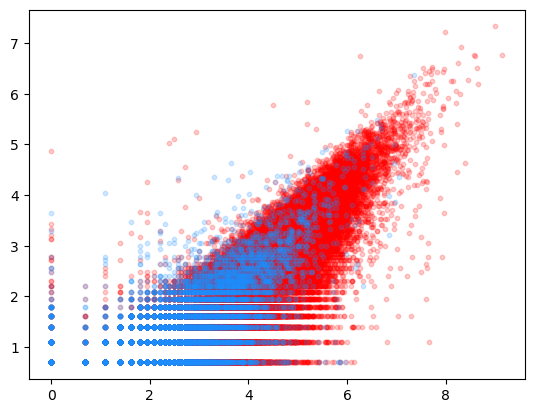

In [123]:
plt.scatter(np.log1p(X_prod.NA18486), np.log1p(X_prod.score), edgecolor=None, 
            facecolor='red', s=10, alpha=0.2)

plt.scatter(np.log1p(X_unprod.NA18486), np.log1p(X_unprod.score), edgecolor=None, 
            facecolor='dodgerblue', s=10, alpha=0.2)

(array([9.638e+03, 8.080e+02, 7.400e+01, 2.700e+01, 1.700e+01, 7.000e+00,
        0.000e+00, 0.000e+00, 4.000e+00, 3.000e+00]),
 array([ -64.,   51.,  166.,  281.,  396.,  511.,  626.,  741.,  856.,
         971., 1086.]),
 <BarContainer object of 10 artists>)

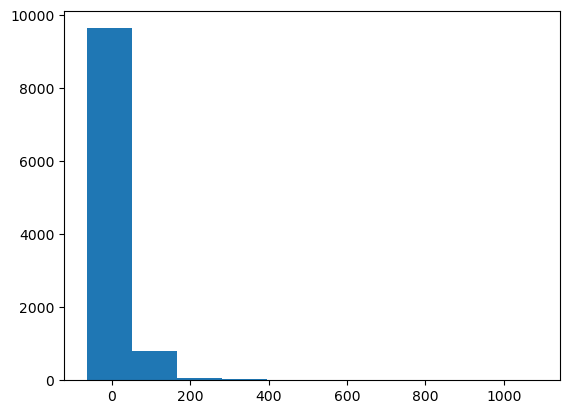

In [137]:
plt.hist(X_unprod.NA18486 - X_unprod.score)

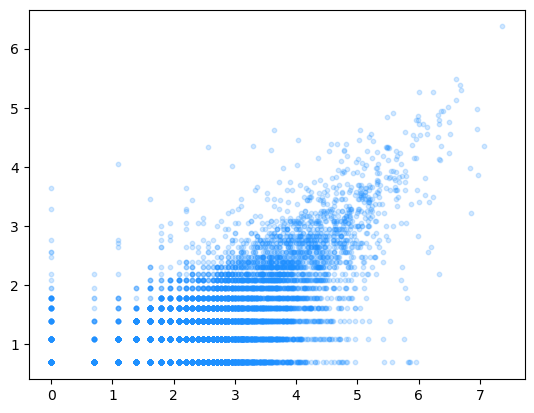

In [55]:
plt.scatter(np.log1p(X_unprod.NA18486), np.log1p(X_unprod.score), edgecolor=None, 
            facecolor='dodgerblue', s=10, alpha=0.2)

/project2/mstephens/cfbuenabadn/anaconda3/envs/jnotebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


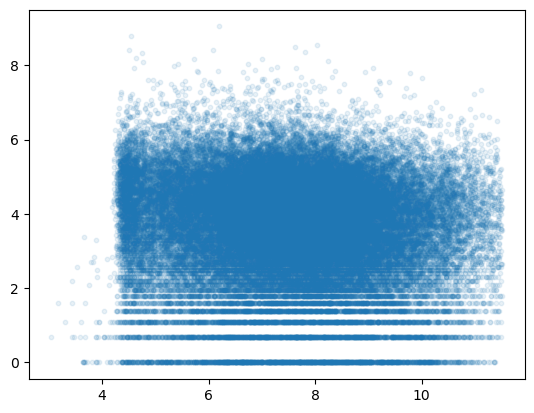

In [45]:
plt.scatter(np.log(X_annot.end - X_annot.start), np.log(np.abs((X_annot.NA18486 - X_annot.score))), s=10, alpha=0.1)

In [47]:
pearsonr(np.log(X_annot.end - X_annot.start), np.log1p(np.abs((X_annot.NA18486 - X_annot.score))))

PearsonRResult(statistic=-0.08772800513429505, pvalue=2.735135269077324e-105)

In [50]:
chRNA

,chrom,start,end,cluster,intron,strand,NA18853,NA19122,NA18523,NA18499,...,NA18498,NA19207,NA19146,NA18876,NA18909,NA19108,NA18505,NA18502,NA19203,NA19128
0,chr1,14829,14930,clu_1_-,chr1:14829:14930:-,-,2,0,0,0,...,0,1,0,0,0,0,0,0,6,0
1,chr1,14829,14970,clu_1_-,chr1:14829:14970:-,-,6,4,1,4,...,0,17,6,2,0,4,14,16,44,1
2,chr1,14829,15021,clu_1_-,chr1:14829:15021:-,-,1,0,0,0,...,0,2,2,0,0,0,2,0,0,1
3,chr1,15947,16607,clu_2_-,chr1:15947:16607:-,-,148,5,36,27,...,3,103,56,16,20,37,26,80,136,9
4,chr1,16310,16607,clu_2_-,chr1:16310:16607:-,-,2,0,10,3,...,0,1,5,3,2,3,1,24,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198241,chr22,50782351,50783045,clu_49245_-,chr22:50782351:50783045:-,-,4,0,2,0,...,0,3,11,2,0,0,4,9,0,10
198242,chr22,50782351,50783501,clu_49245_-,chr22:50782351:50783501:-,-,14,10,4,10,...,4,2,7,6,9,16,4,11,16,11
198243,chr22,50783045,50783501,clu_49245_-,chr22:50783045:50783501:-,-,0,0,0,0,...,4,0,0,0,0,2,0,0,6,4
198244,chr22,50783286,50783391,clu_49245_-,chr22:50783286:50783391:-,-,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [324]:
sns.color_palette("Set1", 10)

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745)]

In [36]:
0.94**9

0.5729948022286164